# Intro to Jupyter Notebook

The information included here follows these webpages: https://realpython.com/jupyter-notebook-introduction/, https://medium.com/ibm-data-science-experience/back-to-basics-jupyter-notebooks-dfcdc19c54bc

## About this Notebook

### Requirements
- Direct access to the input data
- Jupyter notebook installed on that platform
- Python packages:
    - Matplotlib
    - mpl_toolkits
    - NetCDF4
    - Numpy
    
    

### Modes
- The cells are either Python 3 code (next cell), or Markdown (this cell). 
- Modes can be in either of two modes:
    - `EDIT`, which appears green
    - `COMMAND`, which appears blue
- To enter enter `EDIT` mode, hit `Enter` or double click
- To enter `COMMAND` mode, hit `Esc` or click anywhere outside the box

### Navigation
The menus at the top of the page allow you to control the cells, run them, and manage the file. 

### Keyboard commands
Many of the above navigation menus have keyboard shortcuts:

- Command Mode: ESC
- Edit Mode: ENTER
- Run selected cell: CTRL+ENTER
- Run cell and insert below: ALT+ENTER
- Run cell and select below: SHIFT+ENTER

From COMMAND mode:
- Insert cell above: A
- Insert cell below: B
- Cut selected cells: X
- Copy selected cells: C
- Delete selected cell : d+d

## Run the notebook

To run the whole notebook, use the menu: `Kernel > Restart & Run All`, or click the "Fast forward" button on the top menu bar.

To run (or rerun) a single cell, click on the cell and press `Shift, Enter`, or click the "Run" button on the top menu bar.
    

In [1]:
import os

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pygrib
from datetime import datetime, timedelta
from netCDF4 import Dataset
from scipy.interpolate import griddata

# Set up the input files on Hera

Abstractions to change date and location were made, but assuming the final directory structure would remain the same.

In [2]:
# Times
bkg_date = '2023061011'
valid_date = '2023061012'

# Bkg files
bkg_loc = '/work/noaa/wrfruc/span/jedi_summer_retro/nwges/' + bkg_date
file_prefix = valid_date[:-2] + '.' + valid_date[-2:] + '0000'
bkg_dynam_nc = os.path.join(bkg_loc, 'fcst_fv3lam', 'RESTART', file_prefix + '.fv_core.res.tile1.nc')
bkg_tracer_nc = os.path.join(bkg_loc, 'fcst_fv3lam', 'RESTART', file_prefix + '.fv_tracer.res.tile1.nc')

# Gsi files
gsi_loc = '/work/noaa/wrfruc/span/jedi_summer_retro/gsi_prepbufr_analysis/' + valid_date
map_nc = os.path.join(gsi_loc, 'fcst_fv3lam', 'grid_spec.nc')

gsi_dynam_nc = os.path.join(gsi_loc, 'anal_conv_dbz_gsi_temperature187', 'fv3_dynvars')
gsi_tracer_nc = os.path.join(gsi_loc, 'anal_conv_dbz_gsi_temperature187', 'fv3_tracer')

# Jedi files
jedi_loc = '/work/noaa/wrfruc/span/jedi_summer_retro/jedi_prepbufr_analysis/' + valid_date

jedi_dynam_nc = os.path.join(jedi_loc, 'analysis_airTemperature_187_filtered', file_prefix + '.3denvar.c775CONUS.fv_core.res.nc')
jedi_tracer_nc = os.path.join(jedi_loc, 'analysis_airTemperature_187_filtered', file_prefix + '.3denvar.c775CONUS.fv_tracer.res.nc')

# Load files into NetCDF Datasets
bkg_dynam = Dataset(bkg_dynam_nc, 'r')
bkg_tracer = Dataset(bkg_tracer_nc, 'r')
fv3map = Dataset(map_nc, 'r')

gsi_dynam = Dataset(gsi_dynam_nc, 'r')
gsi_tracer = Dataset(gsi_tracer_nc, 'r')
jedi_dynam = Dataset(jedi_dynam_nc, 'r')
jedi_tracer = Dataset(jedi_tracer_nc, 'r')

In [3]:
experiments=["GSI_airTemperature187", "JEDI_airTemperature187", "BACKGROUND"]
# Define the common sub-dictionary for the first three keys ('u', 'v', 'T')
common_dynam = {
    #'GSI_ORIG': gsi_dynam1,
    #'GSI_TerAdjOff': gsi_dynam2,
    #'GSI_TerAdjOff_ObsErrAdjOff': gsi_dynam3,
    experiments[0]: gsi_dynam,
    experiments[1]: jedi_dynam,
    #'JEDI': jedi_dynam,
    #'JEDI 110km0p3sigma': jedi1_dynam,
    #'JEDI 401km0p3sigma': jedi2_dynam,
    #'JEDI 401km0p3sigma_res16': jedi3_dynam,
    experiments[2]: bkg_dynam,
}

# Define the sub-dictionary for the 'sphum' key
sphum_dict = {
    #'GSI_ORIG': gsi_tracer1,
    #'GSI_TerAdjOff': gsi_tracer2,
    #'GSI_TerAdjOff_ObsErrAdjOff': gsi_tracer3,
    experiments[0]: gsi_tracer,
    experiments[1]: jedi_tracer,
    #'JEDI': jedi_tracer,
    #'JEDI 110km0p3sigma': jedi1_tracer,
    #'JEDI 401km0p3sigma': jedi2_tracer,
    #'JEDI 401km0p3sigma_res16': jedi3_tracer,
    experiments[2]: bkg_tracer,
}

# Use dictionary comprehension to build the main dictionary
var_loc = {key: common_dynam for key in ['u', 'v', 'T', 'delp']}
var_loc['sphum'] = sphum_dict

In [4]:
# Load latitude/longitude from background grid spec file
grid_lon = fv3map['grid_lon'][::]
grid_lat = fv3map['grid_lat'][::]

In [5]:
def trim_grid(data, lat, lon):
    '''
    The u, v, and H data are all on grids either one column, or one row smaller than lat/lon. 
    Return the smaller lat, lon grids, given the shape of the data to be plotted.
    '''
    y, x = np.shape(data)
    return lat[:y, :x], lon[:y, :x]

def find_max_index(data):
    '''
    Input parameters:
        data: 3D Numpy array
    Returns:
        Tuple of indices (k, j, i) corresponding to the maximum value in the 3D array
    '''
    # Find the index of the maximum value in the flattened array
    flat_index = np.argmax(np.abs(data))
    
    # Convert the flattened index back to 3D index
    index_3d = np.unravel_index(flat_index, data.shape)
    
    return index_3d

def eq_contours1(data):
    minval = np.amin(data)
    maxval = np.amax(data)
    if minval < 0:
        # Set balanced contours. Choose an odd number in linspace below
        maxval = max(abs(minval), abs(maxval))
        return np.linspace(-maxval, maxval, 21)
    else:
        return np.linspace(minval, maxval, 21)

def eq_contours2(data1, data2):
    minval = np.min([np.amin(data1), np.amin(data2)])
    maxval = np.max([np.amax(data1), np.amax(data2)])
    if minval < 0:
        # Set balanced contours. Choose an odd number in linspace below
        maxval = max(abs(minval), abs(maxval))
        return np.linspace(-maxval, maxval, 21)
    else:
        return np.linspace(minval, maxval, 21)
    
def eq_contours_all(data, title, nclev=21):
    #minval = np.min([np.amin(array) for array in data])
    #maxval = np.max([np.amax(array) for array in data])
    if "for u @" in title or "for v @" in title:
        minval = -5.
        maxval = 5.
    if "for delp @" in title:
        minval = -12.
        maxval = 12.
    else:
        minval = -3
        maxval = 3
    if minval < 0:
        # Set balanced contours. Choose an odd number in linspace below
        maxval = max(abs(minval), abs(maxval))
        return np.linspace(-maxval, maxval, nclev)
    else:
        return np.linspace(minval, maxval, nclev)

In [6]:
def plot_data_2dhori(data, lat, lon, titles, indices, zoom_in=False, plt_level=None):
    
    '''
    Input parameters:
    
        data: 3D Numpy array to be plotted
        lat: 2D Numpy array of latitude
        lon: 2D Numpy array of longitude
        titles: String describing the variable being plotted.
        
    Draws a Basemap representation with the contoured data overlayed, with a colorbar.
        
    ''' 
    (ilev, jlev, klev) = indices[0]
    if plt_level:
        klev = plt_level
    num_datasets = len(data)
    lat_trim, lon_trim = trim_grid(data[0][klev, :, :], lat, lon)
    
    contourLevel = eq_contours_all(data, titles[0], 21)

    fig, axes = plt.subplots(1, num_datasets, figsize=(12*num_datasets, 12), constrained_layout=True)
    if num_datasets == 1:
        axes = [axes]
    
    # Subfigure 1
    for i in range(num_datasets):
        (ilev, jlev, klev) = indices[i]
        ax = axes[i]
        if zoom_in:
            m = Basemap(projection='mill',
                        llcrnrlon=lon.min()+33,
                        urcrnrlon=lon.max()-33,
                        llcrnrlat=lat.min()+11,
                        urcrnrlat=lat.max()-13,
                        resolution='c',
                        ax=ax)
        else:
            m = Basemap(projection='mill',
                        llcrnrlon=lon.min()+1,
                        urcrnrlon=lon.max()-1,
                        llcrnrlat=lat.min()+1,
                        urcrnrlat=lat.max()-1,
                        resolution='c',
                        ax=ax)
        x, y = m(lon_trim, lat_trim)
        cs = m.contourf(x, y, data[i][klev, :, :], contourLevel, cmap='seismic')
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()
        m.drawparallels(np.arange(-90.,120.,5),labels=[1,0,0,0], fontsize=16);
        m.drawmeridians(np.arange(-180.,180.,10),labels=[0,0,0,1], fontsize=16);
        ax.set_title(titles[i], fontsize=24)
    
    cb = fig.colorbar(cs, ax=axes, orientation='horizontal', aspect=50, fraction=0.05, pad=0.05)
    cb.ax.tick_params(labelsize=16)

In [7]:
#direction could be zonal (z, default) or meridional (m)
def plot_data_2dvert(data, lat, lon, titles, indices, direction="z"):
    
    '''
    Input parameters:
    
        data: 3D Numpy array to be plotted
        lat: 2D Numpy array of latitude
        lon: 2D Numpy array of longitude
        titles: String describing the variable being plotted.
        direction: String specifying the orientation of the vertical cross-section alignment.
        
    '''
    num_datasets = len(data)
    contourLevel = eq_contours_all(data, 61)

    fig, axes = plt.subplots(1, num_datasets, figsize=(12*num_datasets, 12), constrained_layout=True)
    if num_datasets == 1:
        axes = [axes]
    
    # Subfigure 1
    for i in range(num_datasets):
        (ilev, jlev) = indices[i]
        ax = axes[i]
        if direction == "z":
            cutoff = 150
            plot_data = data[i][:, jlev, cutoff:-cutoff]
        elif direction == "m":
            cutoff = 75
            plot_data = data[i][:, cutoff:-cutoff, ilev]
        nx = plot_data.shape[1]
        ny = plot_data.shape[0]
        cs = ax.contourf(range(cutoff+1, cutoff+nx+1), range(1, ny+1), plot_data, levels=contourLevel, cmap='seismic')
        
        #cs = m.contourf(x, y, data[i][klev, :, :], contourLevel, cmap='seismic')
        #m.drawcoastlines()
        #m.drawcountries()
        #m.drawstates()
        #m.drawparallels(np.arange(-90.,120.,5),labels=[1,0,0,0], fontsize=16);
        #m.drawmeridians(np.arange(-180.,180.,10),labels=[0,0,0,1], fontsize=16);
        ax.set_title(titles[i], fontsize=24)
    
    cb = fig.colorbar(cs, ax=axes, orientation='horizontal', aspect=50, fraction=0.05, pad=0.05)
    cb.ax.tick_params(labelsize=16)

In [8]:
def plot_data_1dhori(datasets, titles, indices):
    '''
    Input parameters:
        datasets: List of 3D Numpy arrays to be plotted.
        titles: List of strings for titles of each plot.
        indices: List of tuples (i, j, k) corresponding to the indices in each dataset.
    Plots the vertical profiles at the specified coordinates along the k axis.
    '''
    num_datasets = len(datasets)
    if num_datasets != len(titles) or num_datasets != len(indices):
        raise ValueError("The lengths of datasets, titles, and indices must be the same.")
    
    # Create subplots
    fig, axes = plt.subplots(1, num_datasets, figsize=(8 * num_datasets, 6))
    
    # If there's only one dataset, axes is not a list, so we make it iterable
    if num_datasets == 1:
        axes = [axes]
    
    for idx, (data, title, (i, j, k)) in enumerate(zip(datasets, titles, indices)):
        # Extract the vertical profile at the specified coordinates
        horizontal_profile = data[k, j, :]
        maxval = data[k, j, i]
        efolding = maxval/np.exp(1.0)

        count = sum(1 for value in horizontal_profile if np.abs(efolding) <= np.abs(value) <= np.abs(maxval))
        print(f"Number of values falling between {efolding} and {maxval}: {count}")

        start_point = i - 30
        end_point = i + 31
        
        # Plot the vertical profile
        axes[idx].plot(range(start_point, end_point, 1), horizontal_profile[start_point:end_point], '-o')
        axes[idx].set_xlabel('Zonal Grids')
        axes[idx].set_ylabel('Increment')
        axes[idx].set_title(f"{title} Increment at (j {j}, k {k})")
        #axes[idx].invert_yaxis()  # Invert y-axis if k represents depth or altitude
        axes[idx].grid(True)

In [9]:
def plot_data_1dvert(datasets, titles, indices):
    '''
    Input parameters:
        datasets: List of 3D Numpy arrays to be plotted.
        titles: List of strings for titles of each plot.
        indices: List of tuples (i, j) corresponding to the indices in each dataset.
    Plots the vertical profiles at the specified coordinates along the k axis.
    '''
    num_datasets = len(datasets)
    if num_datasets != len(titles) or num_datasets != len(indices):
        raise ValueError("The lengths of datasets, titles, and indices must be the same.")
    
    # Create subplots
    fig, axes = plt.subplots(1, num_datasets, figsize=(8 * num_datasets, 6))
    
    # If there's only one dataset, axes is not a list, so we make it iterable
    if num_datasets == 1:
        axes = [axes]
    
    for idx, (data, title, (i, j)) in enumerate(zip(datasets, titles, indices)):
        # Extract the vertical profile at the specified coordinates
        vertical_profile = data[:, j, i]
        
        # Plot the vertical profile
        axes[idx].plot(vertical_profile, range(len(vertical_profile)), '-o')
        axes[idx].set_xlabel('Increment')
        axes[idx].set_ylabel('Level')
        axes[idx].set_title(f"{title} Increment at (i {i}, j {j})")
        axes[idx].invert_yaxis()  # Invert y-axis if k represents depth or altitude
        axes[idx].grid(True)

In [10]:
def plot_bkg(data, lat, lon, title):
    
    '''
    Input parameters:
    
        data: 2D Numpy array to be plotted
        lat: 2D Numpy array of latitude
        lon: 2D Numpy array of longitude
        var: String describing the variable being plotted.
        
    Draws a Basemap representation with the contoured data overlayed, with a colorbar.
        
    '''
    
    contourLevel = eq_contours1(data)
    
    m = Basemap(projection='mill', 
                llcrnrlon=lon.min()-1,
                urcrnrlon=lon.max()+1,
                llcrnrlat=lat.min()-1,
                urcrnrlat=lat.max()+1,
#                 llcrnrlon=276-10,
#                 urcrnrlon=276+10,
#                 llcrnrlat=35-10,
#                 urcrnrlat=35+10,
                resolution='c',
               )

    lat_trim, lon_trim = trim_grid(data, lat, lon)
    plt.figure(figsize=(12,12))
    x, y = m(lon_trim, lat_trim)
    
    # Check out this link for all cmap options: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    # A good redwhiteblue cmap for increments is seismic, and for full fields with rainbow, change to hsv
    cs = m.contourf(x, y, data, contourLevel, cmap='seismic')
    m.drawcoastlines();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,5),labels=[1,0,0,0], fontsize=16);
    m.drawmeridians(np.arange(-180.,180.,10),labels=[0,0,0,1], fontsize=16);
    plt.colorbar(cs,orientation='vertical', shrink=0.5);
    plt.title(f"{title}", fontdict = {'fontsize' : 24})

# Plot the variables

Loop through each of the variables contained in the keys of `var_loc`, get the data from the appropriate Python variable, and plot the results.

In [11]:
### find the level where variable field has max values
def find_lev_max(var3d):
    nlev=np.shape(var3d)[0]
    varmax=max(np.amax(var3d[i,:,:]) for i  in range(nlev))
#     print(varmax)
    for i in range(nlev):
        if np.amax(var3d[i,:,:])==varmax :
            zmax=i
#     print(zmax)
    return zmax

In [12]:
# # finding level of max T for temp psot
# anl_T, bkg_T = [var_loc["T"][stage]["T"][::] for stage in ['anl', 'bkg']]
# diff=np.squeeze(anl_T)[:, :, :]-np.squeeze(bkg_T)[:, :, :]
# lev=find_lev_max(diff)
# print(lev)
# # plot_data(np.squeeze(anl)[lev, :, :]-np.squeeze(bkg)[lev, :, :], grid_lat, grid_lon, title)

Processing variable: u
Processing variable: v
Processing variable: T
Processing variable: delp
Processing variable: sphum


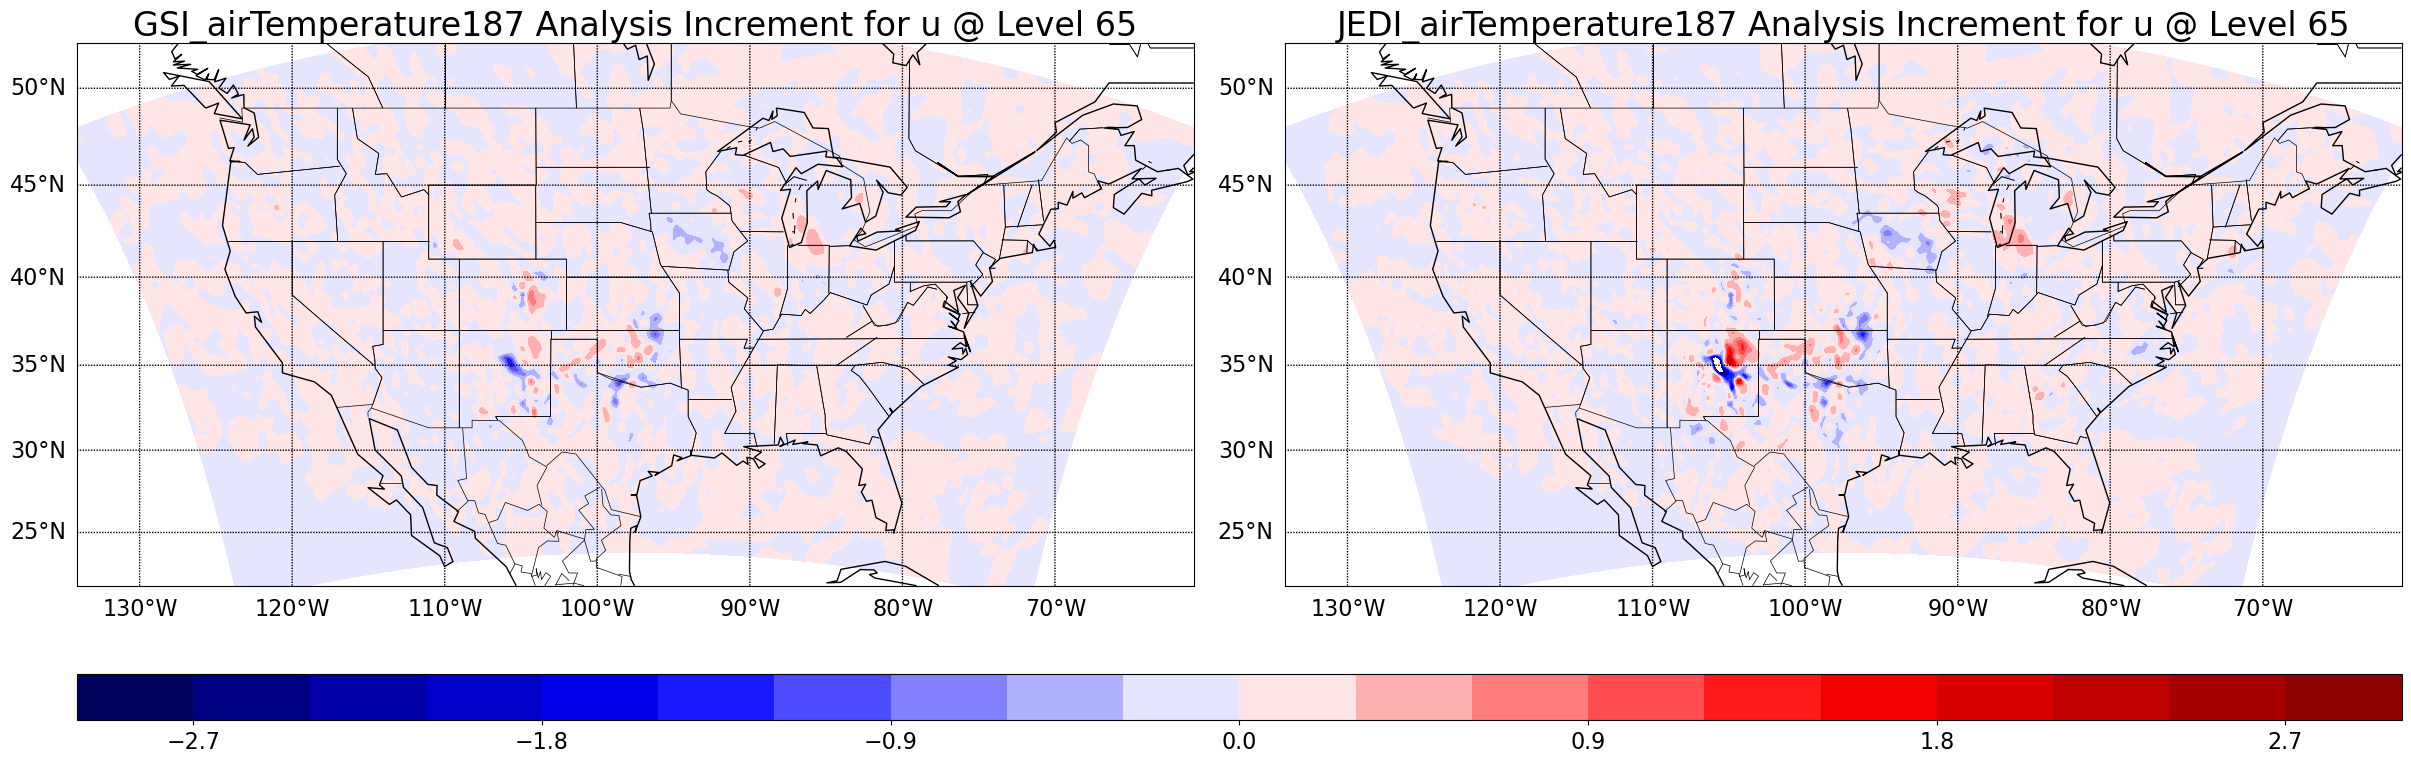

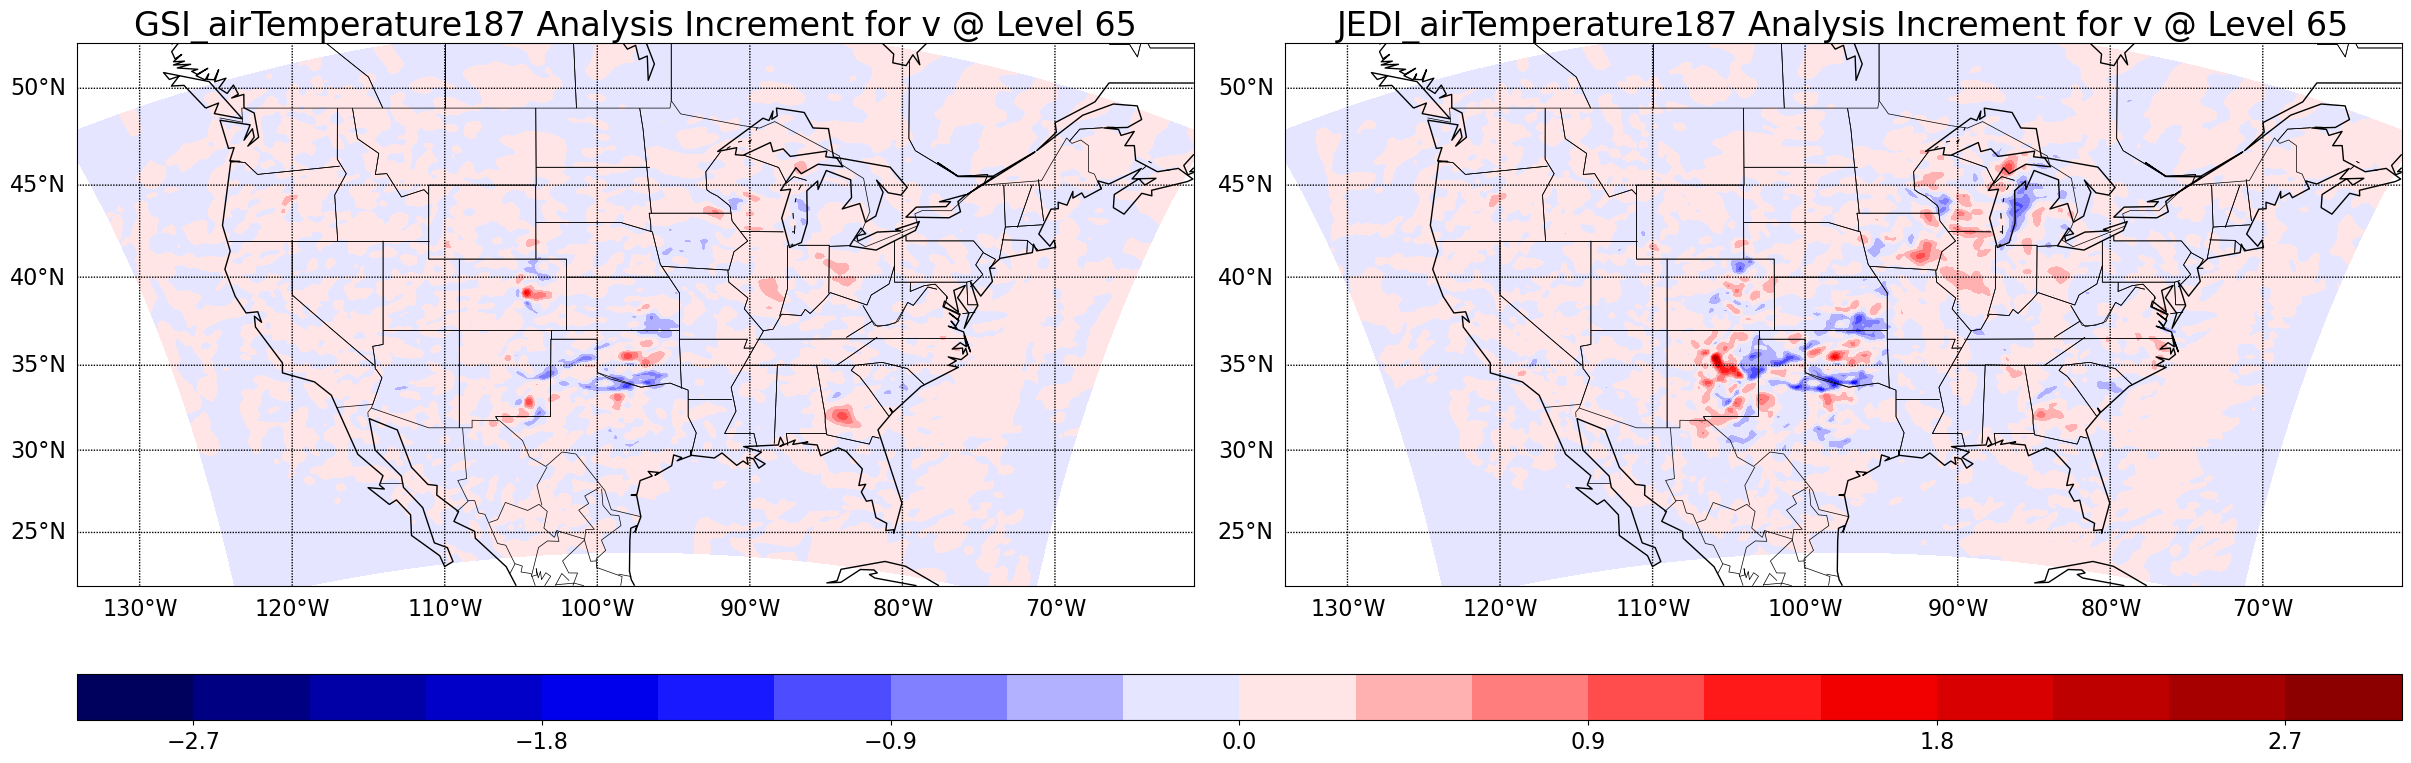

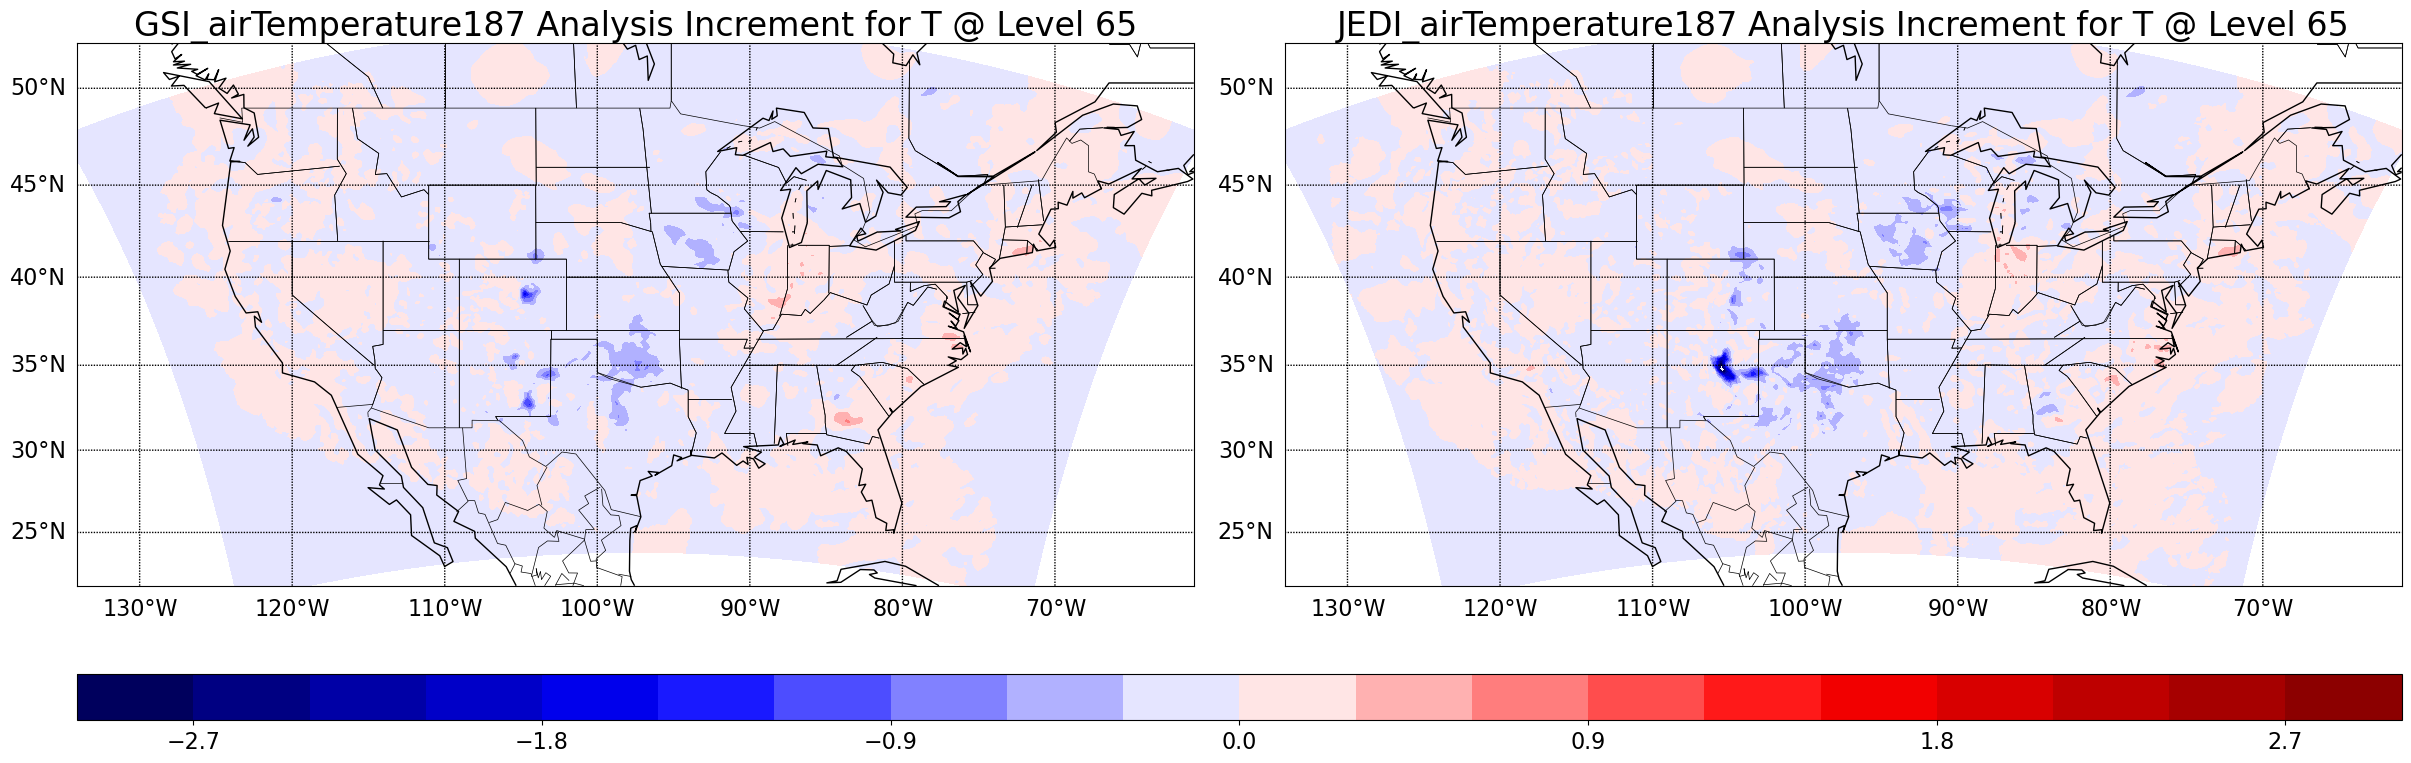

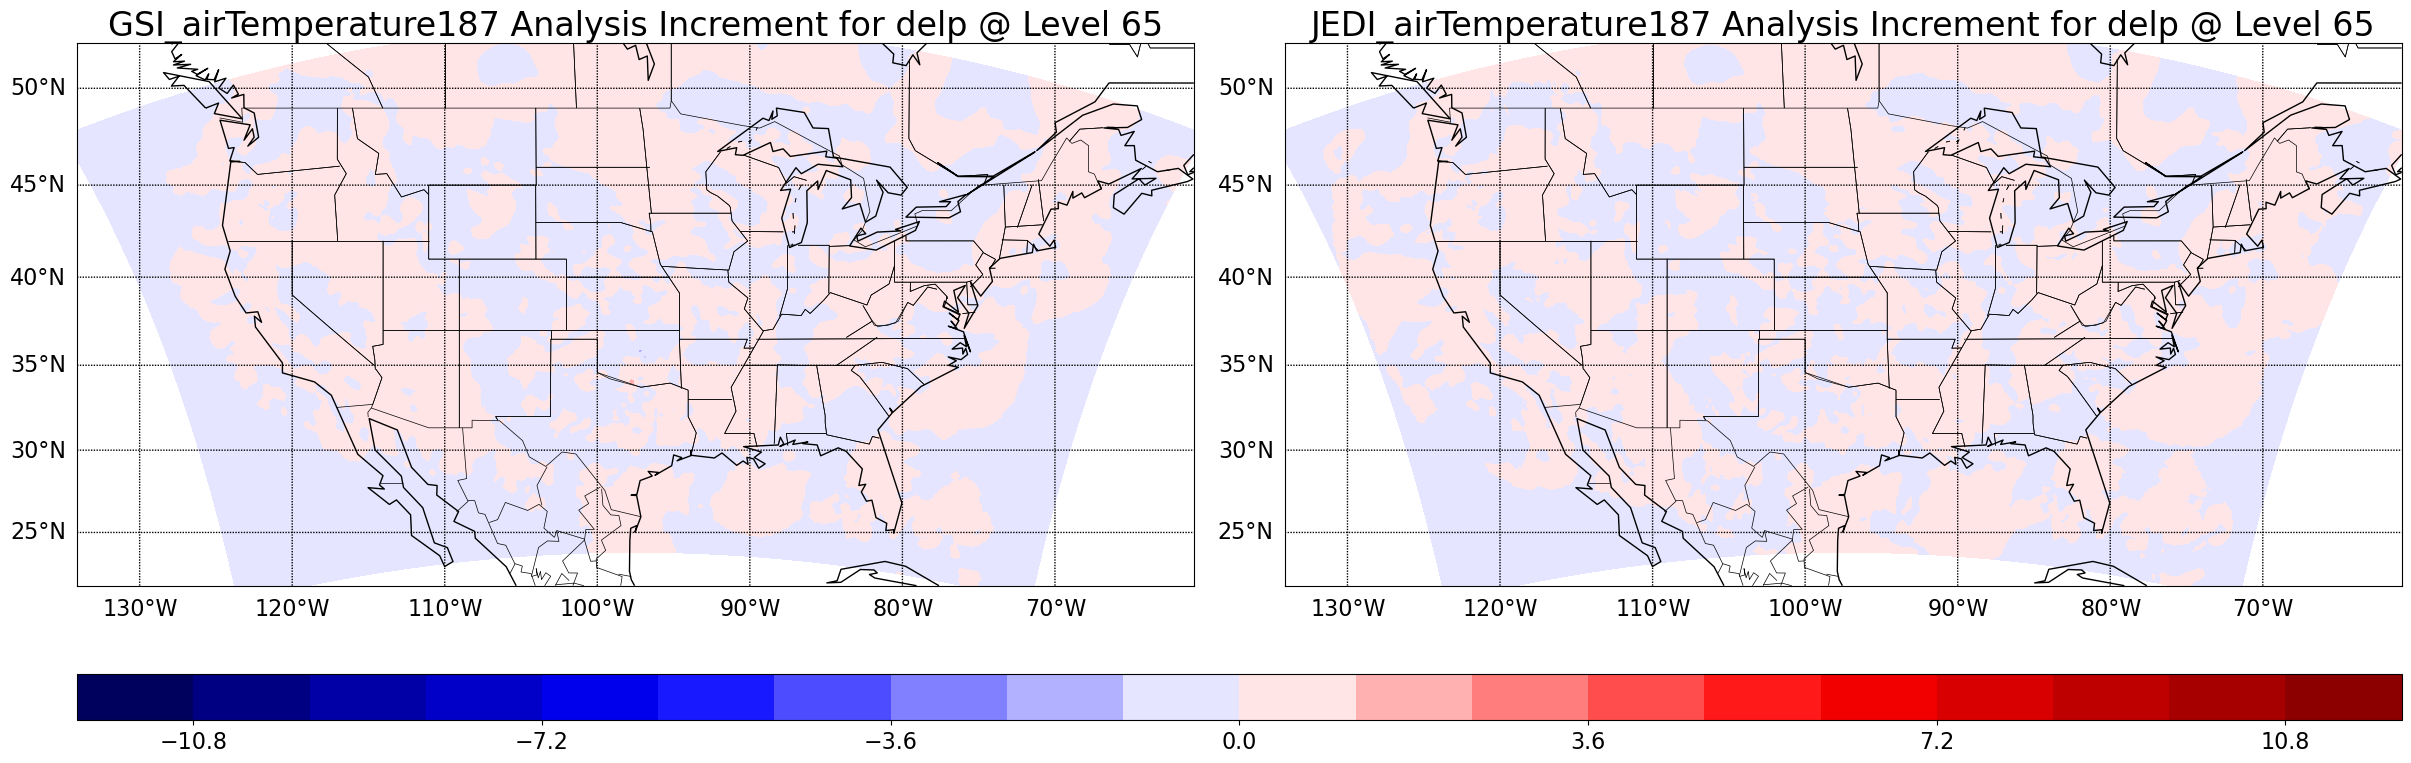

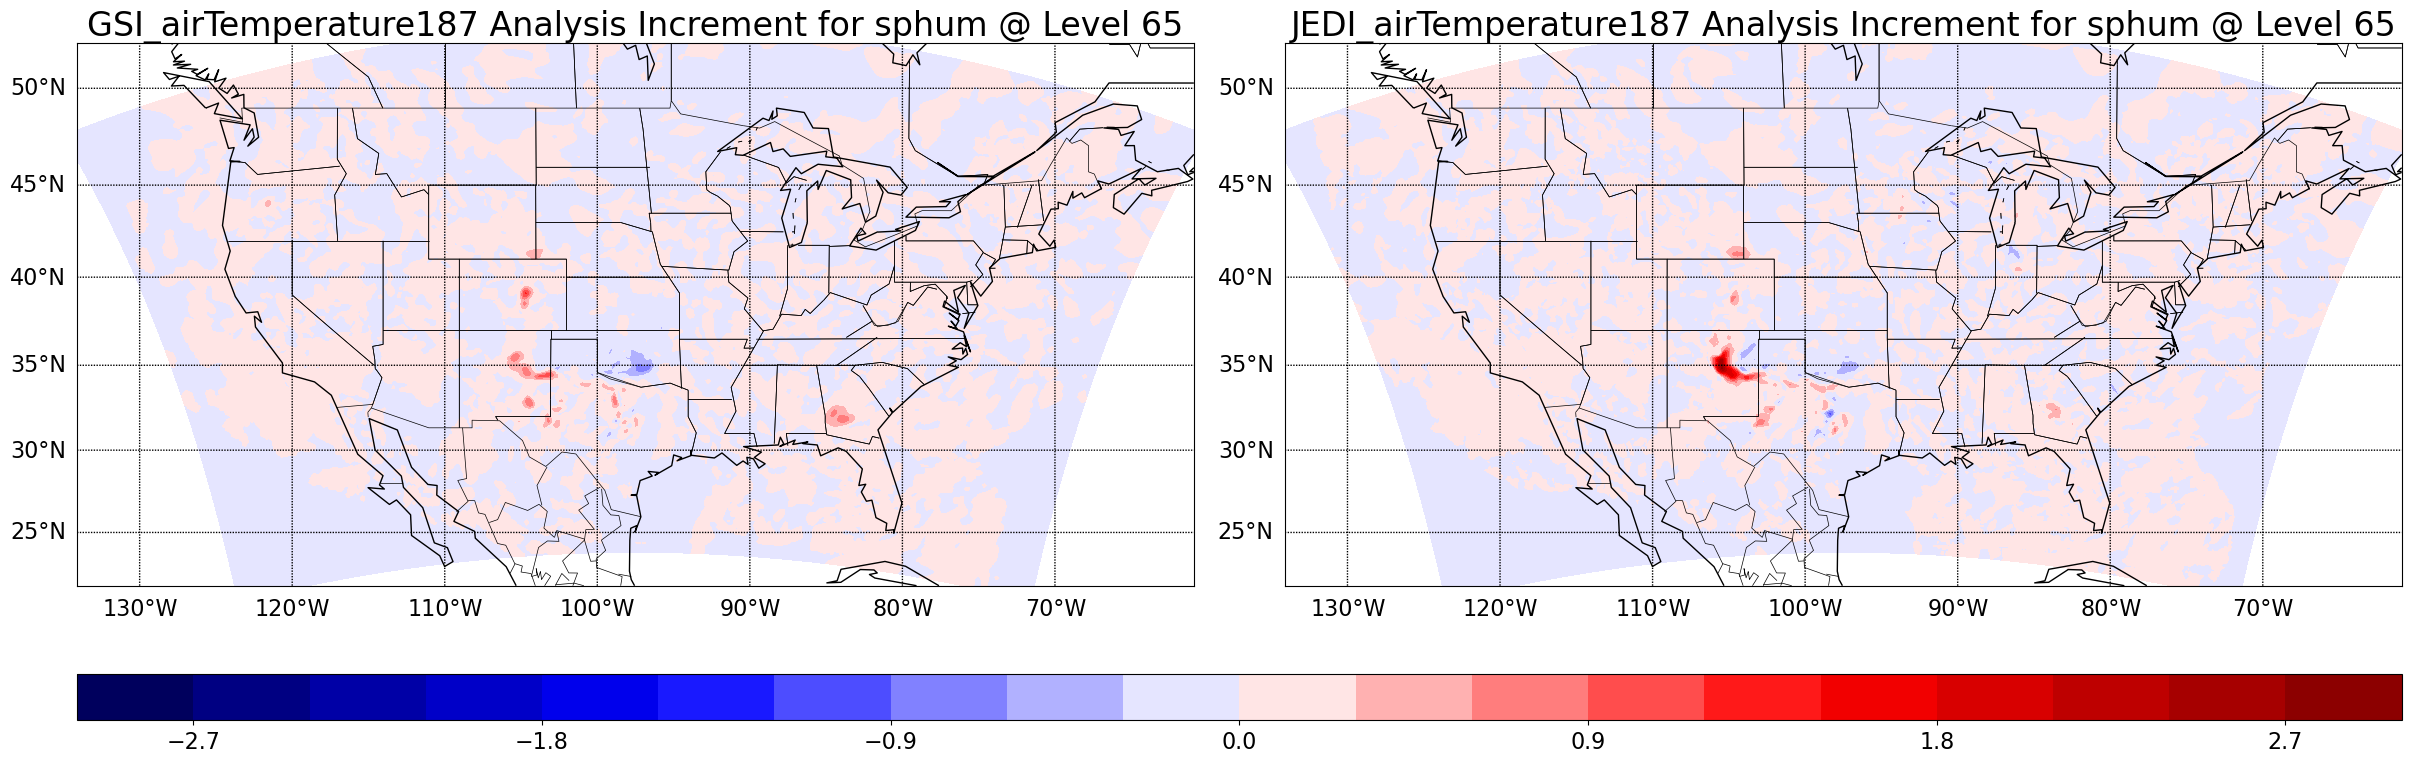

In [13]:
plot_exps = list(common_dynam.keys())[:-1]
plot_level = 64
for var in var_loc.keys():
    
    print("Processing variable: {}".format(var))
    
    titles=[]
    titlesz=[]
    titlesm=[]
    datasets=[]
    indices_vert=[]
    indices_hori=[]
    for stage in plot_exps:
        increment = np.squeeze(var_loc[var][stage][var][::])[:, :, :] - np.squeeze(var_loc[var]["BACKGROUND"][var][::])[:, :, :]
        if var == "sphum":
            increment = increment * 1000.
        datasets.append(increment)
        (k, j, i) = find_max_index(increment)
        indices_vert.append((i, j))
        indices_hori.append((i, j, k))
        if plot_level:
            titles.append(f"{stage} Analysis Increment for {var} @ Level {plot_level+1}")
        else:
            titles.append(f"{stage} Analysis Increment for {var} @ Level {k+1}")
        titlesz.append(f"{stage} Analysis Increment for {var} along j = {j}")
        titlesm.append(f"{stage} Analysis Increment for {var} along i = {i}")
    plot_data_2dhori(datasets, grid_lat, grid_lon, titles, indices_hori, plt_level=plot_level)
    #plot_data_2dvert(datasets, grid_lat, grid_lon, titlesz, indices_vert, "z")
    #plot_data_2dvert(datasets, grid_lat, grid_lon, titlesm, indices_vert, "m")
    #plot_data_1dhori(datasets, plot_exps, indices_hori)
    #plot_data_1dvert(datasets, plot_exps, indices_vert)
    
    
    #datasets=[]
    #indices_vert=[]
    #indices_hori=[]
    #for stage in plot_exps:
    #    data = np.squeeze(var_loc[var][stage][var][::])[:, :, :] - \
    #           np.squeeze(var_loc[var]["BACKGROUND"][var][::])[:, :, :]
    #    if var == "sphum":
    #        data = data * 1000.
    #    datasets.append(data)
    #    (k, j, i) = find_max_index(data)
    #    indices_vert.append((i, j))
    #    indices_hori.append((i, j, 64))
    #plot_data_1dvert(datasets, plot_exps, indices_vert)
    #plot_data_1dhori(datasets, plot_exps, indices_hori)

# Explore the data

In [14]:
for var in var_loc.keys():
    lev = 32   # Change this variable to look at different vertical levels.    
    
    bkg = [var_loc[var]['BACKGROUND'][var][::]]
    data = np.squeeze(bkg)[lev, :, :]
    if var == "sphum":
        data = data * 1000.
    lat_trim, lon_trim = trim_grid(data, grid_lat, grid_lon)
    
    lat_flat = lat_trim.flatten()
    lon_flat = lon_trim.flatten()
    data_flat = data.flatten()
    
    points = np.column_stack((lat_flat, lon_flat))
    
    target_lat = 35.5 
    target_lon = -97.5
    target_point = np.array([[target_lat, target_lon+360]])

    # Perform the interpolation
    if (lat_trim.min() <= target_lat <= lat_trim.max()) and (lon_trim.min() <= target_lon+360 <= lon_trim.max()):
        # Interpolate to find the data value at the given lat and lon
        interpolated_value = griddata(points, data_flat, target_point, method='linear')
        print("Interpolated value at ({}, {}) and level {}: {}".format(target_lat, target_lon, lev+1, interpolated_value))
    else:
        print("Given lat/lon point ({}, {}) is outside the bounds of the data.".format(target_lat, target_lon))
    

Interpolated value at (35.5, -97.5) and level 33: [14.25541289]
Interpolated value at (35.5, -97.5) and level 33: [8.65977205]
Interpolated value at (35.5, -97.5) and level 33: [261.82733583]
Interpolated value at (35.5, -97.5) and level 33: [3110.45234871]
Interpolated value at (35.5, -97.5) and level 33: [2.37702647]


In [15]:
outputVars = ['']